## Potential Talents - Part 2

----

This notebook trains a **mini Word2Vec** model using **Skip-gram with Negative Sampling (SGNS)** on a small corpus, then provides utilities to **explore the vector space** (cosine similarity and classic analogies).

#### Summary:

0) Environment and GPU setup  
1) Load and prepare the corpus  
2) Build the vocabulary (+ `min_count`)  
3) Making training tractable with a large vocabulary  
4) Subsampling  
5) Build training pairs (Skip-gram, dynamic window)  
6) SGNS model, loss, and training  
7) Quick playground (neighbors & analogies)


----


## 0) Envorinment and GPU setup




In [1]:
import re
import math
import random
from collections import Counter
from typing import List, Tuple, Dict

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import sys, torch, platform

In [2]:
print("python:", sys.executable)
print("torch file:", torch.__file__)
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())


python: e:\Devs\pyEnv-1\venvs\Pot-Tals_env\Scripts\python.exe
torch file: e:\Devs\pyEnv-1\venvs\Pot-Tals_env\Lib\site-packages\torch\__init__.py
torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True


In [3]:
#SEED = random.randint(10000, 99999)
#SEED
SEED = 23

In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1) Load / prepare a corpus



In this section we load a compact Wikipedia subset (**text8**, ~17 MB, from Matt Mahoney’s site). It’s already lower-cased and whitespace-tokenized, which makes it perfect for fast Word2Vec experiments without heavy preprocessing.  
We read the file, split into tokens, and keep them intact (no stop-word removal) since frequency effects will be handled later via `min_count` and subsampling.



In [5]:
import os, zipfile, urllib.request

In [6]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [7]:
URL = "http://mattmahoney.net/dc/text8.zip"
ZIP_PATH = os.path.join(DATA_DIR, "text8.zip")
TXT_PATH = os.path.join(DATA_DIR, "text8")  # file inside the zip is named 'text8' (no .txt)


In [8]:
# Download the dataset
if not os.path.exists(ZIP_PATH) and not os.path.exists(TXT_PATH):
    print("Downloading text8...")
    urllib.request.urlretrieve(URL, ZIP_PATH)
    print("Done.")

In [9]:
# Extraction
if os.path.exists(ZIP_PATH) and not os.path.exists(TXT_PATH):
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH) as zf:
        zf.extractall(DATA_DIR)
    print("Done.")


In [10]:
# Load tokens (text8 is already lowercased and space-separated)
with open(TXT_PATH, "r", encoding="utf-8") as f:
    text = f.read()
tokens = text.split()
print(f"Total tokens: {len(tokens):,}")
print("Sample:", tokens[:20])

Total tokens: 17,005,207
Sample: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


## 2) Build vocabulary (+ min_count)

We build the vocabulary and map tokens to integer IDs.  
Only words that appear at least `min_count` times are kept (drops rare noise and speeds up training). We create `stoi/itos` mappings and convert the corpus into an ID sequence (`ids`).  
**Note:** we’re not removing stop-words here, subsampling will thin very frequent words later.

In [11]:
MIN_COUNT = 5  # keep words that appear at least 5 times. I can tweak it later... <--

freq = Counter(tokens)

vocab = {w:c for w,c in freq.items() if c >= MIN_COUNT}


In [12]:
# index -> string
itos = sorted(vocab.keys())

# string -> index                   
stoi = {w:i for i,w in enumerate(itos)}

# Map corpus to ids, dropping rare words
ids = [stoi[w] for w in tokens if w in stoi]

In [13]:
print(itos[:10])


['a', 'aa', 'aaa', 'aaaa', 'aaai', 'aaas', 'aac', 'aachen', 'aafc', 'aage']


In [14]:
for k in sorted(stoi)[:10]:
    print(k, stoi[k])


a 0
aa 1
aaa 2
aaaa 3
aaai 4
aaas 5
aac 6
aachen 7
aafc 8
aage 9


In [15]:
print(ids[:10])

[2588, 46291, 4079, 0, 63653, 45639, 339, 23735, 67385, 1223]


In [16]:
len(ids)/len(tokens)

0.9831602755555989

In [17]:
print(f"Vocab size: {len(itos):,}")
print(f"Corpus length (ids): {len(ids):,}, filtered from rare words (which appear less than {MIN_COUNT} times)")
print("Top 10 most common:", freq.most_common(10))

Vocab size: 71,290
Corpus length (ids): 16,718,844, filtered from rare words (which appear less than 5 times)
Top 10 most common: [('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644)]


## 3) Making training tractable with a large vocabulary

### Problem

- Vocabulary size $|V| = 71{,}290$, embedding size $D = 300$.
- Skip-gram uses **two** $D \times |V|$ matrices (input + output):
  $$
  2 \times |V| \times D = 2 \times 71{,}290 \times 300 = 42{,}774{,}000
  $$
  → a **large network** plus an expensive full softmax over $|V|$ for every training pair.

### Solution

**Subsampling (frequent tokens)**
- Keep each token $w$ with probability $p_{\text{keep}}(w)$ that decreases with its frequency.
- Greatly **reduces the number of training pairs** while preserving co-occurrence structure in expectation.

**Negative Sampling (SGNS)**
- Replace the full softmax with a small set of **binary** predictions per pair (one positive context, a few sampled negatives), so **each update touches only a tiny subset of embeddings**, making training scalable.



## 4) Subsampling

**Subsampling: keep probability $p_{\text{keep}}(w)$**
$$

$$

**Goal.** Thin very frequent words without deleting them outright, speed up training while preserving context geometry.

**Definitions**
- $f(w)$: relative frequency of word \(w\) in the original token stream: $\text{count}(w)/\text{total tokens}$.
- $t$: small threshold, typically $10^{-5}$ – $10^{-4}$.

**Original (Mikolov, 2013)**  
$$
p_{\text{keep}}(w)=\min\!\left(1,\ \sqrt{\frac{t}{f(w)}}\right)
$$

**Gensim-style (more forgiving for mid/low frequencies)**  
$$
p_{\text{keep}}(w)=\min\!\left(1,\ \sqrt{\frac{t}{f(w)}}+\frac{t}{f(w)}\right)
$$

**Behavior**
- If $f(w)\le t$: $p_{\text{keep}}\approx 1$ (rare words kept).
- If $f(w)\gg t$: $p_{\text{keep}}$ is small (frequent words thinned).
- If a word occurs $c_w$ times, kept count $\tilde c_w \sim \mathrm{Binomial}(c_w, p_{\text{keep}})$ with $\mathbb{E}[\tilde c_w]=c_w\,p_{\text{keep}}$.

Let’s plot these formulas to better understand the **dynamics** of subsampling.

In [18]:
import matplotlib.pyplot as plt

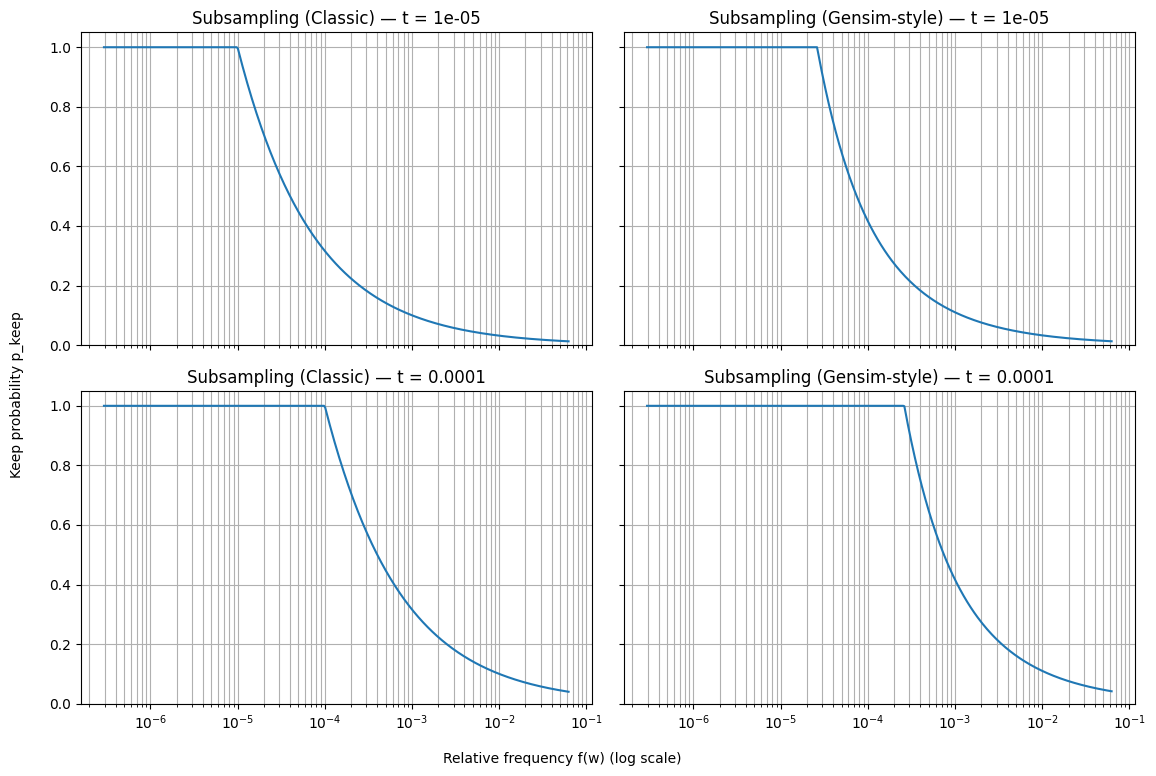

In [19]:
# keep-probability formulas:
# classic
def p_keep_classic(f, t):
    f = np.asarray(f, dtype=float)
    return np.minimum(1.0, np.sqrt(t / f))

# gensim-style
def p_keep_gensim(f, t):
    f = np.asarray(f, dtype=float)
    return np.minimum(1.0, np.sqrt(t / f) + (t / f))

# build frequency grid from corpus
total_tokens = sum(freq.values())
freq_prop = np.array([freq[w] / total_tokens for w in vocab.keys()], dtype=float)

f_min = float(freq_prop.min()) if len(freq_prop) else 1.0 / max(total_tokens, 1)
f_max = float(freq_prop.max()) if len(freq_prop) else f_min * 10

# ensure strictly positive
f_min = max(f_min, 1.0 / total_tokens)
if not np.isfinite(f_min) or not np.isfinite(f_max) or f_min >= f_max:
    f_min, f_max = 1e-8, 1e-1

f_grid = np.logspace(np.log10(f_min), np.log10(f_max), 400)

# plot: 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

settings = [
    ("Classic", 1e-5, p_keep_classic),
    ("Gensim-style", 1e-5, p_keep_gensim),
    ("Classic", 1e-4, p_keep_classic),
    ("Gensim-style", 1e-4, p_keep_gensim),
]

for ax, (label, t, fn) in zip(axs.ravel(), settings):
    y = fn(f_grid, t)
    ax.semilogx(f_grid, y)
    ax.set_ylim(0, 1.05)
    ax.grid(True, which="both")
    ax.set_title(f"Subsampling ({label}) — t = {t:g}")

fig.text(0.5, 0.04, "Relative frequency f(w) (log scale)", ha="center")
fig.text(0.04, 0.5, "Keep probability p_keep", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.show()


**Conclusion (Subsampling)**
- Words with **high relative frequency** (e.g., stopwords) have a **low keep probability** and are **heavily thinned**.
- Because thinning is **probabilistic per token** (Bernoulli with $p_{\text{keep}}(w)$), very frequent words are **not removed entirely**; a small, representative sample remains, which helps **preserve co-occurrence structure** while reducing compute.
- **Rare words** ($f(w)\le t$) are **largely unaffected** ($p_{\text{keep}}\approx 1$).
- Increasing $t$ (e.g., $10^{-5}\rightarrow10^{-4}$) **raises** $p_{\text{keep}}$ for a given $f$ and shifts the drop-off to the right, making subsampling **less aggressive** (more tokens kept).
- The **Gensim-style** rule keeps slightly **more** mid-frequency words than the classic rule; at very high $f$, both behave similarly.


In [20]:
# Subsampling config:
SUBSAMPLE_T = 1e-4
USE_GENSIM_STYLE = True   

In [21]:
# Relative frequencies computed on the ORIGINAL stream (before min_count filtering)
total_tokens = sum(freq.values())
freq_prop = {w: freq[w] / total_tokens for w in vocab} 

In [22]:
# p_keep function
def keep_probability(f, t=SUBSAMPLE_T, gensim_style=USE_GENSIM_STYLE):
    if t is None:
        return 1.0
    base = math.sqrt(t / f)
    return min(1.0, base + (t / f)) if gensim_style else min(1.0, base)


In [23]:
# Apply subsampling over the original tokens
tokens_sub = []
dropped = 0
for w in tokens:
    if w not in stoi:         # we skip the words removed by min_count
        continue
    f = freq_prop[w]
    if random.random() < keep_probability(f):
        tokens_sub.append(w)
    else:
        dropped += 1


In [24]:
# print results
print(f"Before subsampling: {len(tokens):,} tokens")
print(f"After  subsampling: {len(tokens_sub):,} tokens  "
      f"(dropped {dropped:,} -> {dropped/len(tokens):.1%})")

# Re-map to ids for training on the subsampled stream
ids = [stoi[w] for w in tokens_sub]
print(f"IDs length (post-subsample): {len(ids):,}")


Before subsampling: 17,005,207 tokens
After  subsampling: 9,411,845 tokens  (dropped 7,306,999 -> 43.0%)
IDs length (post-subsample): 9,411,845


In [25]:
import pandas as pd

In [26]:
counts_sub = Counter(tokens_sub)
N = sum(freq.values())

# keep-prob helpers
def p_keep_classic(f, t): 
    return min(1.0, np.sqrt(t/f))
def p_keep_gensim(f, t):
    return min(1.0, np.sqrt(t/f) + (t/f))

def p_keep(f, t=SUBSAMPLE_T, gensim_style=True):
    return p_keep_gensim(f, t) if gensim_style else p_keep_classic(f, t)

rows = []
K = 20
for w, c in freq.most_common(K):
    f_rel = c / N
    pk = p_keep(f_rel, SUBSAMPLE_T, gensim_style=USE_GENSIM_STYLE)
    kept = counts_sub[w]
    kept_pct = kept / c if c else 0.0
    exp_kept = int(round(c * pk))
    rows.append({
        "word": w,
        "count_before": c,
        "count_after": kept,
        "kept_pct_actual": kept_pct,
        "p_keep_theory": pk,
        "expected_kept": exp_kept,
        "abs_diff_pct": abs(kept_pct - pk)
    })

# convert dec to %
df_keep = pd.DataFrame(rows).assign(
    kept_pct_actual=lambda d: (d["kept_pct_actual"]*100).round(2),
    p_keep_theory=lambda d: (d["p_keep_theory"]*100).round(2),
    abs_diff_pct=lambda d: (d["abs_diff_pct"]*100).round(2)
)

# display
cols = ["word","count_before","count_after","expected_kept","kept_pct_actual","p_keep_theory","abs_diff_pct"]
df_keep[cols]


,word,count_before,count_after,expected_kept,kept_pct_actual,p_keep_theory,abs_diff_pct
0,the,1061396,44202,44185,4.16,4.16,0.00
1,of,593677,33430,33474,5.63,5.64,0.01
2,and,416629,28074,28318,6.74,6.80,0.06
3,one,411764,28078,28162,6.82,6.84,0.02
4,in,372201,26857,26859,7.22,7.22,0.00
5,a,325873,25231,25241,7.74,7.75,0.00
6,to,316376,25051,24895,7.92,7.87,0.05
7,zero,264975,22969,22928,8.67,8.65,0.02
8,nine,250430,22428,22337,8.96,8.92,0.04
9,two,192644,19897,19800,10.33,10.28,0.05


Text(0.5, 1.0, 'Top-10 words: before vs after subsampling (and expected)')

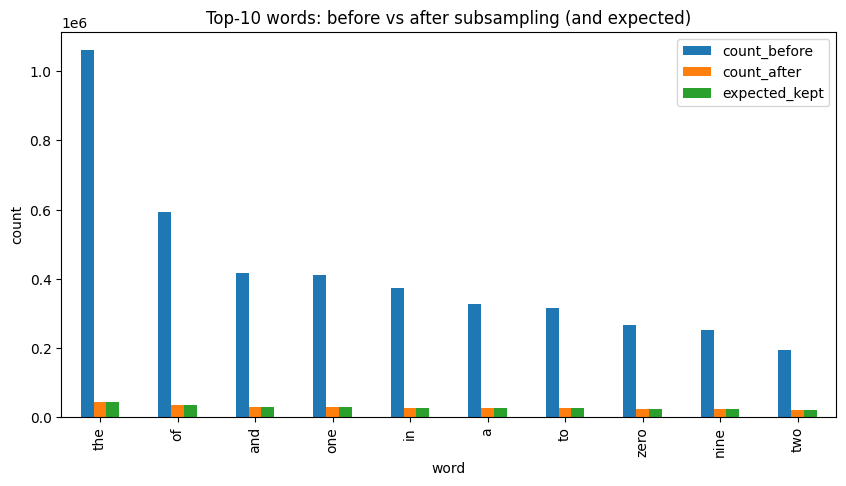

In [27]:
top10 = df_keep.head(10).copy()
ax = top10.plot(x="word", y=["count_before","count_after","expected_kept"], kind="bar", figsize=(10,5))
ax.set_ylabel("count")
ax.set_title("Top-10 words: before vs after subsampling (and expected)")


Subsampling minimizes compute and preserves co-occurrence structure better than hard stopword removal. We gain a truer geometry and avoid the bias created by collapsing sentences when tokens are deleted.


## 5) Build trainig pairs (skip-gram, dynamic window)

We’ll follow the **Skip-gram** architecture from Figure 1 of the paper "Efficient Estimation of Word Representations in
Vector Space" ref: https://arxiv.org/abs/1301.3781 (Mikolov et al., 2013):  
given a **center word** $w_t$, the model predicts its **context words** $w_{t+j}$.


From 

![./sup_imgs/CBOW_Skip-gram.png](./sup_imgs/CBOW_Skip-gram.png)


**Objective**
$$
\max \sum_{t}\sum_{j\in[-r,\,r]\setminus\{0\}} \log p\big(w_{t+j}\mid w_t\big)
$$

**Training recipe (what we implement)**
- **Dynamic window**: $r \sim \mathrm{Uniform}\{1,\dots,W\}$.
- Two embedding matrices: $E_{\text{in}}$ (center) and $E_{\text{out}}$ (context).  
  The word vector we use after training is the row from $E_{\text{in}}$.
- **Negative Sampling**: for each positive pair $(w_t, w_{t+j})$, draw $k$ negatives to
  approximate the softmax efficiently.

**Why Skip-gram first?**
- Simple to implement, **strong for rare words**, and aligns with the classic Word2Vec setup.
(We can add **CBOW** later for a speed/quality comparison.)


### 5.1) Negative Sampling

Training a neural network usually means **slightly adjusting many weights** for each example. In Skip-gram, that’s a problem: with a large vocabulary, the output layer is huge, so a standard softmax would try to update **every** output weight on **every** pair.

**Negative Sampling** changes the game. For each positive pair $(\text{center}, \text{context})$, we:
- keep the **positive** context word, and
- sample a **small set of “negative” words** (words that should score 0 for this center).

We then make **binary predictions** only for these $k{+}1$ words (the one positive and a few negatives). The update touches:
- the **input embedding** of the center word, and
- the **output embeddings** of just the positive and sampled negatives.

All other output weights are ignored for this step. The result is that each example updates **only a tiny subset** of parameters, making training **fast and scalable**, while still teaching the model to pull true contexts closer and push random words away.


### Negative sampling: how we draw negatives

We sample “negative” words from a unigram distribution so that more frequent words are more likely to be chosen; the paper uses a smoothed version.

**Raw unigram (by relative frequency)**  
  $$
  P(w_i)=\frac{f(w_i)}{\sum_{j=1}^{|V|} f(w_j)}
  $$

**Smoothed unigram (preferred, with \(3/4\) power)**  
  $$
  P(w_i)=\frac{f(w_i)^{3/4}}{\sum_{j=1}^{|V|} f(w_j)^{3/4}}
  $$

Where $f(w)$ is the corpus count of word $w$. The $3/4$ exponent flattens the distribution: it slightly downweights very common words and upweights less frequent ones, yielding more informative negatives.


In [28]:
from torch.utils.data import IterableDataset, DataLoader

In [29]:
# window + negatives
WINDOW_MAX   = 5           # dynamic window upper bound
NEGATIVE_K   = 10          # negatives per positive
BATCH_SIZE   = 8192 if torch.cuda.is_available() else 1024

# negative sampling distribution with the unigram^(3/4)
power = 0.75
counts = np.array([vocab[w] for w in itos], dtype=np.float64)
unigram_pow = counts ** power
neg_prob = unigram_pow / unigram_pow.sum()


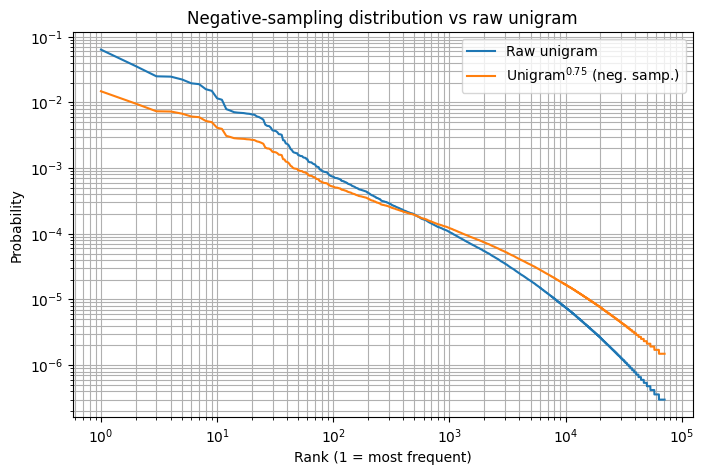

In [30]:
# Plot the negative sampling distribution

# Raw unigram prob and smoothed (unigram^0.75)
raw_prob = counts / counts.sum()
neg_prob = (counts ** 0.75)
neg_prob = neg_prob / neg_prob.sum()

# Rank–probability plot (log–log): raw vs smoothed
order_raw = np.argsort(-raw_prob)
order_neg = np.argsort(-neg_prob)

plt.figure(figsize=(8,5))
plt.loglog(np.arange(1, len(itos)+1), raw_prob[order_raw], label="Raw unigram")
plt.loglog(np.arange(1, len(itos)+1), neg_prob[order_neg], label="Unigram$^{0.75}$ (neg. samp.)")
plt.xlabel("Rank (1 = most frequent)")
plt.ylabel("Probability")
plt.title("Negative-sampling distribution vs raw unigram")
plt.legend()
plt.grid(True, which="both")
plt.show()


**Observation**: The unigram^0.75 curve will sit above raw for mid/low-frequency words and below raw for the very top words, that’s the **“flattening”** effect.

##### But, there's an implementation problem:

For every positive pair we train on, you need *k* negative words drawn from a non-uniform distribution (`neg_prob`, unigram^0.75).
If we have millions of pairs, that’s hundreds of millions of draws!

Doing `np.random.choice(..., p=neg_prob)` every time is relatively slow (it has to process the whole probability vector each draw).

Then, there's a simple trick to avoid this: prebuild a big jar of tickets (`neg_table`) where **each word ID appears as often as its probability**.

Then, when you need negatives, you don’t recompute anything, we just pick random positions in that jar!

In [31]:
# build a big table for fast sampling
NEG_TABLE_SIZE = max(1_000_000, 100 * len(itos))
neg_table = np.random.choice(len(itos), size=NEG_TABLE_SIZE, p=neg_prob)


In [32]:
def sample_negatives(batch_size: int, k: int) -> torch.Tensor:
    idx = np.random.randint(0, NEG_TABLE_SIZE, size=(batch_size, k))
    return torch.tensor(neg_table[idx], dtype=torch.long)


In [33]:
# iterable dataset: stream (center, context) pairs
class SkipGramPairs(IterableDataset):
    def __init__(self, ids, window_max):
        super().__init__()
        self.ids = np.asarray(ids, dtype=np.int32)
        self.window_max = window_max

    def _iter_range(self, start, end, seed=None):
        """
        Yield (center, context) skip-gram pairs for center indices in [start, end).

        For each center position i, sample a dynamic window radius r ~ Uniform{1..window_max}
        using a local RNG (seeded for reproducibility). Emit one training example for every
        neighbor j in [i-r, i+r] , with bounds clipped to [0, len(ids)).

        Args:
            start (int): Inclusive start index of the center positions.
            end (int): Exclusive end index of the center positions.
            seed (int, optional): Seed for a local random.Random instance so window
                sampling is deterministic given the same inputs.

        Yields:
            Tuple[int, int]: (center_id, context_id) for a single positive pair.

        Notes:
            - The window is dynamic (varies per center occurrence).
            - Context positions may cross the [start, end) shard boundary; only centers
              are restricted to the shard. This preserves edge contexts.
        """
        rng = random.Random(seed)
        for i in range(start, end):
            center = int(self.ids[i])
            r = rng.randint(1, self.window_max)
            left  = max(0, i - r)
            right = min(len(self.ids), i + r + 1)
            for j in range(left, right):
                if j == i: 
                    continue
                yield center, int(self.ids[j])

    def __iter__(self):
        """
        Stream (center, context) pairs; sharded when DataLoader uses multiple workers.

        If running with a single worker, iterate over the full corpus [0, n).
        If multiple workers are present, split the center index range into disjoint
        shards and call _iter_range(start, end, seed=SEED + worker_id) so that each
        worker produces a deterministic, non-overlapping subset of pairs.

        Yields:
            Tuple[int, int]: (center_id, context_id) pairs generated on the fly.

        Notes:
            - Using IterableDataset avoids materializing all pairs in memory.
            - Seeding per worker makes results reproducible while keeping windows
              independent across workers.
        """
        # split work across dataloader workers
        info = torch.utils.data.get_worker_info()
        n = len(self.ids)
        if info is None:
            # single worker
            yield from self._iter_range(0, n, seed=SEED)
        else:
            # shard per worker for deterministic coverage
            w_id, w_num = info.id, info.num_workers
            start = (n * w_id) // w_num
            end   = (n * (w_id + 1)) // w_num
            yield from self._iter_range(start, end, seed=SEED + w_id)


The dataset above **streams** Skip-gram pairs on the fly, so we never materialize all $(\text{center}, \text{context})$ pairs in RAM.

- **Input:** `ids` = the whole corpus as integer word IDs `[w0, w1, w2, …]`.  
  For each position $i$ (center), sample a radius $r\in\{1,\dots,\text{window\_max}\}$ and emit one example for each neighbor $j\in[i-r,\,i+r]\setminus\{i\}$.
- **Why `IterableDataset`?** Counting pairs first is expensive and depends on random windows. Streaming avoids precomputation.



In [34]:
dataset = SkipGramPairs(ids, WINDOW_MAX)


In [35]:
def collate_skipgram(batch):
    # batch = list of (center, context)
    centers, positives = zip(*batch)
    centers  = torch.tensor(centers,  dtype=torch.long)
    positives= torch.tensor(positives,dtype=torch.long)
    negatives= sample_negatives(len(batch), NEGATIVE_K)
    return centers, positives, negatives

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_skipgram,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)


In [36]:
# quick test: pull one batch and print shapes
centers, positives, negatives = next(iter(loader))
print("centers:", centers.shape, "positives:", positives.shape, "negatives:", negatives.shape)


centers: torch.Size([8192]) positives: torch.Size([8192]) negatives: torch.Size([8192, 10])


In [37]:
for i in range(10):
    print("example pair:", centers[i].item(), "->", positives[i].item(), "| word:", itos[centers[i].item()], "->", itos[positives[i].item()])


example pair: 2588 -> 46291 | word: anarchism -> originated
example pair: 2588 -> 63653 | word: anarchism -> term
example pair: 2588 -> 339 | word: anarchism -> abuse
example pair: 46291 -> 2588 | word: originated -> anarchism
example pair: 46291 -> 63653 | word: originated -> term
example pair: 63653 -> 46291 | word: term -> originated
example pair: 63653 -> 339 | word: term -> abuse
example pair: 339 -> 2588 | word: abuse -> anarchism
example pair: 339 -> 46291 | word: abuse -> originated
example pair: 339 -> 63653 | word: abuse -> term


In [38]:
centers[:10]

tensor([ 2588,  2588,  2588, 46291, 46291, 63653, 63653,   339,   339,   339])

In [39]:
positives[:10]

tensor([46291, 63653,   339,  2588, 63653, 46291,   339,  2588, 46291, 63653])

In [40]:
negatives[:10]

tensor([[46977, 62967, 44248, 35007, 44903, 35159, 28316, 63879, 37921, 45639],
        [62904,  3376,  2241, 44556, 55756, 68220, 10991, 61839, 50644,  6117],
        [64423, 63867, 48521, 30977,  2645, 63561,     0, 43602, 30219, 50984],
        [67733, 28689, 18366, 69558, 53007,  2316,  1085, 70025, 36767,  6030],
        [26652, 50636, 40341, 63316, 58174, 57775, 22179, 22208, 33118, 28308],
        [47554, 45944, 16228, 24694, 58040, 24660, 12317, 30311, 30227, 11901],
        [12804, 17498, 22476, 45676, 71089, 42088, 28244,  4079, 57847,  2645],
        [53456, 63879, 46968, 39394, 31472, 68354, 59877, 17591, 38975, 53243],
        [ 4974, 46184, 12723, 13963, 43121,  4567, 25694, 36589, 46123,  4183],
        [19918, 24577, 63879, 42890, 26798, 30611,  4931, 17515, 15062, 62885]])

**Observations**

1) **centers**  
   - Shape: `[8192]`  
   - Meaning: for each training example (row in the batch), this is the center word ID.

2) **positives**  
   - Shape: `[8192]`  
   - Meaning: for each example, `positives[i]` is one context word ID produced by the dynamic window at that center position.  
   - **Note:** the **same center word can appear with different positive words** across rows; that’s expected with a sliding, random window.

3) **negatives**  
   - Shape: `[B, K]`  
   - Meaning: for each example $i$, `negatives[i]` holds the $K$ negative word IDs sampled for that $(\text{center}, \text{positive})$ pair.


##### Summary (pairs & negatives)

- We generate **Skip-gram pairs** on the fly with a **dynamic window**.
- For each positive pair we sample **K negatives** from the unigram\(^{0.75}\) distribution.
- Batches have shapes: `centers [B]`, `positives [B]`, `negatives [B, K]`.
- Only embeddings touched per step: center, its positive context, and the K negatives.

## 6) SGNS model, loss, and training

In [41]:
import torch.nn.functional as F

In [42]:
EMBED_DIM = 300  # we prefer to start small (100–300)

class SGNS(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int):
        super().__init__()
        self.emb_in  = nn.Embedding(vocab_size, embed_dim)   # input/center
        self.emb_out = nn.Embedding(vocab_size, embed_dim)   # output/context
        self._init()

    def _init(self):
        # Xavier for stability
        nn.init.xavier_uniform_(self.emb_in.weight)
        nn.init.xavier_uniform_(self.emb_out.weight)

    def forward(self, centers, positives, negatives):
        """
        centers:   [B]      word IDs (input/center)
        positives: [B]      word IDs (true context)
        negatives: [B, K]   word IDs (sampled negatives)

        Returns:
            pos_logits: [B]
            neg_logits: [B, K]
        """
        # Embeddings
        v_c = self.emb_in(centers)            # [B, D]
        v_p = self.emb_out(positives)         # [B, D]
        v_n = self.emb_out(negatives)         # [B, K, D]

        # formulation
        C = v_c.unsqueeze(1)                  # [B, 1, D]
        P = v_p.unsqueeze(1)                  # [B, 1, D]
        all_ctx = torch.cat([P, v_n], dim=1)  # [B, 1+K, D]
        logits = torch.matmul(all_ctx, C.transpose(1, 2)).squeeze(-1)  # [B, K+1]

        pos_logits = logits[:, 0]             # [B]
        neg_logits = logits[:, 1:]            # [B, K]
        return pos_logits, neg_logits


**Notes on this SGNS head**

- We **never** build $|V|$-dim one-hot vectors. `nn.Embedding` is a row lookup into $E_\text{in}, E_\text{out}\in\mathbb{R}^{|V|\times D}$, equivalent to one-hot$\times E$ but $O(1)$.
- The forward pass scores only **$K{+}1$** outputs per example (1 positive + $K$ negatives) by dotting the center vector with the selected output rows, no full $|V|$-way softmax.
- Complexity per example: **$O((K{+}1)D)$** instead of **$O(|V|D)$**.
- The returned logits feed the SGNS loss (maximize $\sigma(\text{pos})$, minimize $\sigma(\text{neg})$).
- After training, you can use **$E_\text{in}$**, **$E_\text{out}$**, or their **average**. In this notebook we will use the **average** $(E_\text{in}+E_\text{out})/2$.


In [43]:
def sgns_loss(pos_logits, neg_logits):
    """
    pos_logits: [B]
    neg_logits: [B, K]
    """
    B = pos_logits.size(0)

    pos_sum = F.logsigmoid(pos_logits).sum(dim=0)          # scalar

    neg_logp = F.logsigmoid(-neg_logits)                   # [B, K]
    neg_sum_over_k = neg_logp.sum(dim=1)                   # [B]   
    neg_sum = neg_sum_over_k.sum(dim=0)                    # scalar
    #neg_sum = F.logsigmoid(-neg_logits).sum()     <- same as

    return -(pos_sum + neg_sum) / B

### SGNS loss: what this code does

We have:
- `pos_logits`: shape $[B]$ with scores $s_i^{(+)} = u_{c_i}^\top v_{w_i}$ for each positive pair.
- `neg_logits`: shape $[B,K]$ with scores $s_{i,k}^{(-)} = u_{n_{i,k}}^\top v_{w_i}$ for each of the $K$ negatives.

The **Skip-gram with Negative Sampling** objective **to maximize** (per batch) is:
  
  $$
  \mathcal{J}
  \;=\;
  \frac{1}{B}\sum_{i=1}^{B}
  \left[
    \log\sigma\!\big(s_i^{(+)}\big)
    \;+\;
    \sum_{k=1}^{K}\log\sigma\!\big(-\,s_{i,k}^{(-)}\big)
  \right],
  $$
  
where $\sigma(x)=\frac{1}{1+e^{-x}}$.  
We **minimize** the loss $\mathcal{L} = -\mathcal{J}$.

**Code mapping**
- `F.logsigmoid(pos_logits)` computes $\log \sigma(s_i^{(+)})$ (vector $[B]$); `.sum()` adds over the batch.
- `F.logsigmoid(-neg_logits)` computes $\log \sigma(-s_{i,k}^{(-)})$ (matrix $[B,K]$); `.sum()` adds over batch and negatives.
- We then divide by $B$ to average **per example** (common choice; some implementations average by $B(K{+}1)$).

Concretely, the loss is:

  $$
  \mathcal{L}
  \;=\;
  -\frac{1}{B}\left(
    \sum_{i=1}^{B}\log\sigma\!\big(s_i^{(+)}\big)
    \;+\;
    \sum_{i=1}^{B}\sum_{k=1}^{K}\log\sigma\!\big(-\,s_{i,k}^{(-)}\big)
  \right).
  $$

**Why `logsigmoid`?**  
Numerical stability. Computing `torch.log(torch.sigmoid(x))` can underflow for large $|x|$; `F.logsigmoid` uses a stable formulation.

**Intuition (gradients):**
- Positives: minimizing $-\log\sigma(s)$ **pushes $s$ up** (pulls center and true context closer).
- Negatives: minimizing $-\log\sigma(-s)$ **pushes $s$ down** (pushes center away from sampled negatives).

> Equivalent form with BCE-with-logits:
> 
> - positives: labels = 1  
> - negatives: labels = 0  
>  
> Summing both and dividing by $B$ yields the same objective.


In [44]:
model = SGNS(vocab_size=len(itos), embed_dim=EMBED_DIM).to(device)


In [45]:
from time import perf_counter

In [46]:
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
GRAD_NORM = 5.0

# We can cap steps per "epoch" since IterableDataset has no length
STEPS_PER_EPOCH = 5000
EPOCHS = 5


The training loop:

In [47]:
#training loop
for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = perf_counter()
    running = 0.0
    for step, (centers, positives, negatives) in enumerate(loader, 1):
        centers   = centers.to(device, non_blocking=True)
        positives = positives.to(device, non_blocking=True)
        negatives = negatives.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True) #each step resets grads so each update uses only the current batch
        pos_logits, neg_logits = model(centers, positives, negatives)
        loss = sgns_loss(pos_logits, neg_logits)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_NORM) #prevents exploding gradients
        optimizer.step()

        running += loss.item()
        if step % 100 == 0:
            print(f"epoch {epoch} step {step}/{STEPS_PER_EPOCH} - loss {running/100:.4f}")
            running = 0.0

        if step >= STEPS_PER_EPOCH:
            break

    dt = perf_counter() - t0
    print(f"Epoch {epoch} done in {dt:.1f}s")


epoch 1 step 100/5000 - loss 6.8286
epoch 1 step 200/5000 - loss 4.7064
epoch 1 step 300/5000 - loss 4.1288
epoch 1 step 400/5000 - loss 3.8988
epoch 1 step 500/5000 - loss 3.6774
epoch 1 step 600/5000 - loss 3.6091
epoch 1 step 700/5000 - loss 3.6076
epoch 1 step 800/5000 - loss 3.5698
epoch 1 step 900/5000 - loss 3.4958
epoch 1 step 1000/5000 - loss 3.4542
epoch 1 step 1100/5000 - loss 3.4803
epoch 1 step 1200/5000 - loss 3.4408
epoch 1 step 1300/5000 - loss 3.3904
epoch 1 step 1400/5000 - loss 3.4235
epoch 1 step 1500/5000 - loss 3.4053
epoch 1 step 1600/5000 - loss 3.3688
epoch 1 step 1700/5000 - loss 3.3399
epoch 1 step 1800/5000 - loss 3.3858
epoch 1 step 1900/5000 - loss 3.3283
epoch 1 step 2000/5000 - loss 3.3400
epoch 1 step 2100/5000 - loss 3.3864
epoch 1 step 2200/5000 - loss 3.3593
epoch 1 step 2300/5000 - loss 3.3252
epoch 1 step 2400/5000 - loss 3.2940
epoch 1 step 2500/5000 - loss 3.3524
epoch 1 step 2600/5000 - loss 3.3397
epoch 1 step 2700/5000 - loss 3.3210
epoch 1 st

In [48]:
os.makedirs("checkpoints", exist_ok=True)
torch.save({
    "model_state": model.state_dict(),
    "itos": itos,
    "config": {"embed_dim": EMBED_DIM}
}, "checkpoints/sgns_text8.pt")
print("Saved to checkpoints/sgns_text8.pt")


Saved to checkpoints/sgns_text8.pt


In [ ]:
@torch.no_grad() #don’t track gradients inside this function
def get_emb(model, which="avg"):
    if which=="in":  E = model.emb_in.weight
    if which=="out": E = model.emb_out.weight
    if which=="avg": E = (model.emb_in.weight + model.emb_out.weight)/2
    E = E.float(); E = E/(E.norm(dim=1, keepdim=True)+1e-12)
    return E

emb = get_emb(model).to("cpu")

In [50]:
emb.shape

torch.Size([71290, 300])

### Extracted embedding matrix

- **Shape:** `emb.shape = torch.Size([71290, 300])` → $ |V| \times D $.  
- **Meaning:** each row is a **word embedding**. Here we use the **average** of input and output embeddings, L2-normalized for cosine similarity:
$$
E_i \leftarrow \frac{E_i}{\lVert E_i \rVert_2 + 10^{-12}}
$$
- **Computation:** wrapped with `@torch.no_grad()` to avoid gradient tracking.


## 7) quick playground (neighbors & analogies)

In [51]:
# index helpers
word_to_id = stoi
id_to_word = itos

@torch.no_grad()
def most_similar(query, topk=10):
    qid = word_to_id[query]
    q = emb[qid:qid+1]                    # [1, D], keeps a 2-D tensor
    sims = (emb @ q.T).squeeze(1)         # [V]
    sims[qid] = -1                        # exclude self
    top = torch.topk(sims, topk).indices.tolist()
    return [(id_to_word[i], float(sims[i])) for i in top]

@torch.no_grad()
def analogy(a, b, c, topk=10):
    va = emb[word_to_id[a]]
    vb = emb[word_to_id[b]]
    vc = emb[word_to_id[c]]
    v = vb - va + vc
    v = v / (v.norm() + 1e-12)
    sims = emb @ v
    for w in (a, b, c): sims[word_to_id[w]] = -1  # exclude self
    top = torch.topk(sims, topk).indices.tolist()
    return [(id_to_word[i], float(sims[i])) for i in top]


#### 7.1) Quick neighbors

In [52]:
for w in ["king","queen","paris","france","computer","music","river","church"]:
    if w in word_to_id:
        print(w, "→", [x for x,_ in most_similar(w, topk=8)])


king → ['valdemar', 'sigismund', 'pretender', 'vasa', 'anjou', 'crowned', 'sobieski', 'jehoshaphat']
queen → ['elizabeth', 'highness', 'victoria', 'consort', 'hrh', 'monarch', 'margrethe', 'majesty']
paris → ['montparnasse', 'cimeti', 'marne', 'sur', 'conservatoire', 'arrondissement', 'lausanne', 'universelle']
france → ['belgium', 'nantes', 'spain', 'alsace', 'toulouse', 'bordeaux', 'etienne', 'normandie']
computer → ['hardware', 'computers', 'peripherals', 'programmable', 'atanasoff', 'computing', 'mainframe', 'minicomputer']
music → ['reggae', 'folk', 'bluegrass', 'polyphonic', 'jazz', 'electronica', 'techno', 'disco']
river → ['rivers', 'tributaries', 'yangtze', 'tributary', 'ganges', 'nile', 'brahmaputra', 'tigris']
church → ['anglican', 'episcopal', 'churches', 'communion', 'archdiocese', 'congregationalist', 'autocephaly', 'methodist']


#### 7.2) Analogies

In [67]:
for a,b,c in [
    ("man","king","woman"),      # man : king :: woman : ?
    ("paris","france","italy"),  # paris : france :: ? : italy
    ("good","better","bad"),     # morphology-ish
]:
    if all(w in word_to_id for w in (a,b,c)):
        print(f"{a}:{b} :: {c}: ?", [(x[0], round(x[1],3)) for x in analogy(a,b,c,topk=8)])


man:king :: woman: ? [('anjou', 0.657), ('heir', 0.65), ('daughter', 0.647), ('concubine', 0.644), ('matilda', 0.644), ('consort', 0.642), ('empress', 0.641), ('valois', 0.641)]
paris:france :: italy: ? [('belgium', 0.681), ('germany', 0.67), ('spain', 0.655), ('hungary', 0.64), ('austria', 0.639), ('greece', 0.636), ('netherlands', 0.636), ('luxembourg', 0.614)]
good:better :: bad: ? [('worse', 0.699), ('fared', 0.696), ('fare', 0.625), ('inflated', 0.625), ('stripper', 0.624), ('stymied', 0.622), ('slimmer', 0.62), ('undeserved', 0.618)]


#### 7.3) Odd-one-out (which word doesn’t fit?)

In [68]:
def odd_one_out(words):
    ok = [w for w in words if w in word_to_id]
    V = torch.stack([emb[word_to_id[w]] for w in ok])     # [n, D]
    centroid = V.mean(0); centroid = centroid / (centroid.norm()+1e-12)
    sims = (V @ centroid)                                  # [n]
    idx = int(torch.argmin(sims))
    return ok[idx], [(x[0], round(x[1],3)) for x in list(zip(ok, sims.tolist()))]

print( odd_one_out(["paris","london","rome","germany","madrid"]) )
print( odd_one_out(["cat","dog","cow","banana","horse"]) )


('germany', [('paris', 0.827), ('london', 0.747), ('rome', 0.793), ('germany', 0.693), ('madrid', 0.841)])
('banana', [('cat', 0.893), ('dog', 0.896), ('cow', 0.85), ('banana', 0.781), ('horse', 0.814)])


#### 7.4) Relation directions (are “king−man ≈ queen−woman”?)

In [55]:
def direction(a,b):
    va, vb = emb[word_to_id[a]], emb[word_to_id[b]]
    d = vb - va; return d / (d.norm()+1e-12)

for (a1,b1),(a2,b2) in [
    (("man","woman"), ("king","queen")),
    (("paris","france"), ("rome","italy")),
]:
    if all(w in word_to_id for w in [a1,b1,a2,b2]):
        cos = float(direction(a1,b1) @ direction(a2,b2))
        print(f"dir({a1}→{b1}) · dir({a2}→{b2}) = {cos:.3f}")


dir(man→woman) · dir(king→queen) = 0.134
dir(paris→france) · dir(rome→italy) = 0.405


#### 7.5) Tiny 2-D map (PCA) of chosen words

In [56]:
from sklearn.decomposition import PCA

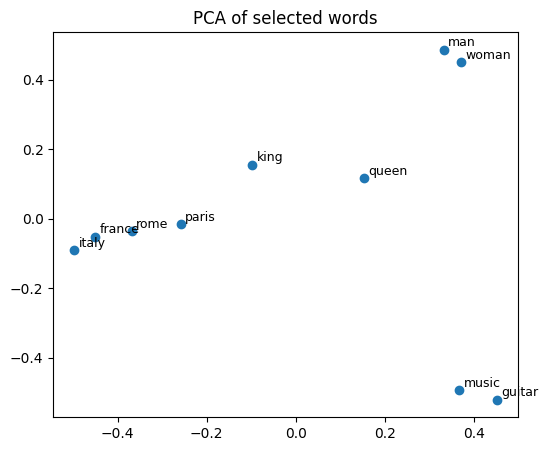

In [57]:

def plot_words(words):
    ws = [w for w in words if w in word_to_id]
    X = torch.stack([emb[word_to_id[w]] for w in ws]).cpu().numpy()
    X2 = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1])
    for (x,y),w in zip(X2, ws): plt.text(x+0.01, y+0.01, w, fontsize=9)
    plt.title("PCA of selected words"); plt.show()

plot_words(["king","queen","man","woman","paris","france","rome","italy","guitar","music"])


The gender/royalty relation is captured: the vector from man → woman points in roughly the same direction as king → queen, and the pairs are close, evidence the model encodes analogous relations.

Geographic terms cluster: paris–france and rome–italy sit near each other along the same axis, while music–guitar forms a separate pocket far from the geo cluster, showing topical separation.

#### 7.6) Cosine similarity to 'car' (distribution and top-10 marked)

In [58]:
@torch.no_grad()
def sim_hist(query, bins=60, topk=10):
    qid = word_to_id[query]
    sims = (emb @ emb[qid]).cpu().numpy()     # cosine = dot (rows normalized)
    sims[qid] = -1
    top = np.argpartition(-sims, topk)[:topk]
    plt.figure(figsize=(7,4))
    plt.hist(sims, bins=bins, range=(-0.2, 1.0))
    for i in top: plt.axvline(sims[i], ls="--", alpha=0.4)
    plt.title(f"Cosine similarity to '{query}'"); plt.xlabel("cosine"); plt.ylabel("count")
    plt.show()
    return [(id_to_word[i], float(sims[i])) for i in top[np.argsort(-sims[top])]]


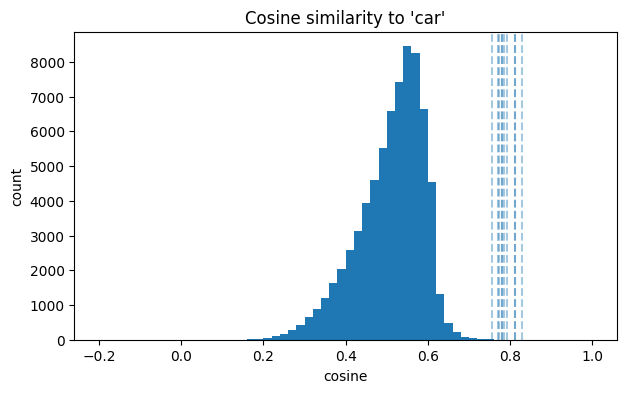

[('cars', 0.8291821479797363),
 ('truck', 0.8127455711364746),
 ('driver', 0.8116132020950317),
 ('automobile', 0.7917213439941406),
 ('motorcycle', 0.7849061489105225),
 ('racing', 0.7803171873092651),
 ('nascar', 0.7799419164657593),
 ('porsche', 0.7736354470252991),
 ('volkswagen', 0.7695461511611938),
 ('bicycle', 0.7570672631263733)]

In [59]:
sim_hist("car")

#### 7.7) Local 2-D map around a query (neighbors vs background)

In [60]:
@torch.no_grad()
def local_map(query, topk=100, background=1000, label_top=20):
    qid = word_to_id[query]
    sims = emb @ emb[qid]
    sims[qid] = -1
    top = torch.topk(sims, topk).indices

    bg_idx = torch.randint(0, emb.size(0), (background,))
    V = torch.cat([emb[top], emb[qid:qid+1], emb[bg_idx]])   # [topk + 1 + bg, D]
    Y = PCA(n_components=2, random_state=0).fit_transform(V.cpu().numpy())

    n_top = topk; q_pt = n_top
    xs, ys = Y[:,0], Y[:,1]
    plt.figure(figsize=(6,5))
    plt.scatter(xs[n_top+1:], ys[n_top+1:], s=8, alpha=0.25, label="background")
    plt.scatter(xs[:n_top], ys[:n_top], s=30, alpha=0.9, label="neighbors")
    plt.scatter(xs[q_pt], ys[q_pt], s=80, marker="*", label=query)
    for i in range(min(label_top, n_top)):
        plt.text(xs[i]+0.01, ys[i]+0.01, id_to_word[int(top[i])], fontsize=8)
    plt.legend(); plt.title(f"Local PCA map around '{query}'"); plt.show()


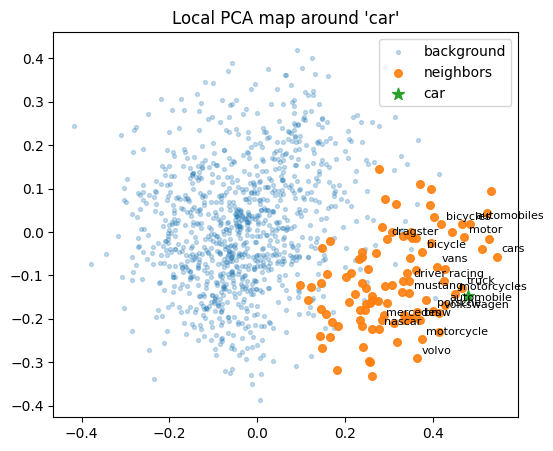

In [61]:
local_map("car")

Neighbors (orange) densely occupy one region, dominated by vehicle types (truck, vans, automobile, dragster), brands (mercedes, volvo, volkswagen), and variants (cars, motor), a coherent semantic neighborhood around car.

Background words (blue) spread diffusely across the space, indicating most vocabulary is far from the car region, the tight orange cluster highlights how the embedding concentrates semantically related words.

----